# Music name generator
Well here we are. I'm going to find THE best music name, thanks to machine learning

In [ ]:
import numpy as np 
import pandas as pd 
import string
import matplotlib.pyplot as plt
import pickle

import os
for dirname, _, filenames in os.walk('/home/goznalo/Programming/Python/musicnames'):
    for filename in filenames:
        if "checkpoints" not in dirname:
            if ".git" not in dirname:
                print(os.path.join(dirname, filename))

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

%matplotlib inline

/home/goznalo/Programming/Python/musicnames/artists.csv
/home/goznalo/Programming/Python/musicnames/miusic.ipynb
/home/goznalo/Programming/Python/musicnames/Untitled.ipynb
/home/goznalo/Programming/Python/musicnames/.gitattributes
/home/goznalo/Programming/Python/musicnames/generator.ipynb
/home/goznalo/Programming/Python/musicnames/README.md
/home/goznalo/Programming/Python/musicnames/variables/case4/char_to_index.pkl
/home/goznalo/Programming/Python/musicnames/variables/case4/index_to_char.pkl
/home/goznalo/Programming/Python/musicnames/variables/case4/validchars.pkl
/home/goznalo/Programming/Python/musicnames/variables/case4/numchars.pkl
/home/goznalo/Programming/Python/musicnames/variables/case4/m.pkl
/home/goznalo/Programming/Python/musicnames/variables/case4/max_char.pkl
/home/goznalo/Programming/Python/musicnames/variables/case3/char_to_index.pkl
/home/goznalo/Programming/Python/musicnames/variables/case3/index_to_char.pkl
/home/goznalo/Programming/Python/musicnames/variables/ca

### Importing the data
Let's import the data from the kaggle dataset music-artists-popularity, using the Pandas library.

In [ ]:
filename = '/home/goznalo/Programming/Python/musicnames/artists.csv'
dataset = pd.read_csv(filename, usecols = [2], dtype=str) # Obtain the artist name column.

In [ ]:
dataset.head # preview of the data

### Clearing, part 1
We don't want any of the NaN entries, nor duplicate names. We will also convert it to a numpy array for posterior transformations.

In [ ]:
df = dataset.dropna(axis = 0,how = 'any',thresh = None).drop_duplicates(subset=None) #removing NaN's and converting to numpy.
names = np.squeeze(np.asarray(df))

In [ ]:
len(names)

In [ ]:
names[0]

### Clearing, part 2
We will now remove all those names using non-standard characters. What I mean by non-standard is all those characters not being latin ones, nor punctuation ones, nor digits, nor spaces. For instance, we will get rid of those using chinese characters or greek letters.

If we try applying the .isalnum() method, we quickly run into trouble as these non-latin characters return True. We need to come up with a solution. One way around this is by using the string module. With it, the string.printable characters are those we want to allow in our names, therefore we make a set out of them, which will be used against the names of the database in a loop.

In [ ]:
validchars = {}
validchars[0] = set(string.printable)
print(validchars[0])

Now comes the loop. An initial approach was creating a new object, a numpy array, to which we would append each valid name, therefore discarding the rest of the names with invalid characters. However, the appending operation makes the algorithm take exponential time of completion. Instead, we can save the index of each invalid word in a list, which we then feed to the np.delete() function to remove those entries of the "names" array

In [ ]:
clearedlist = {}
def deletechars(validcharacters, listofnames, verbose=False):  # We define it within a function, as we will need it in the next steps
    i = 0 # counts each iteration
    j = 0 # counts each invalid word
    deletelist= []
    for name in listofnames:
        if not all(char in validcharacters for char in name):
            deletelist.append(i)
            if j%10000 == 0 and verbose:
                print("invalid: " + name)
            j += 1
        i += 1
        if i%50000 == 0 and verbose:
            print(str(i) + " cases inspected.")
    return np.delete(listofnames, deletelist)

clearedlist[0] = deletechars(validchars[0], names) #by default, verbose = False (no output)

In [ ]:
clearedlist[0][0:22] # Check that Beyoncé has been correctly removed.

In [ ]:
np.savetxt("clearlists/clearedlist1.csv", clearedlist[0], delimiter=",", fmt='%s') #save the list to a csv file.

### Clearing, part 3: choose your own adventure
We will now distinguish four different cases which can be studied, with decreasing complexity. 
1. The full list, as is.
2. The list, having removed punctuation characters and digits.
3. The list, having removed both punctuation characters, digits and names with more than two words.
4. The list, having removed both punctuation characters, digits and names with more than one word.

Case 2 is easy to implement, just applying the previously defined deletechars() function, specifying punctuation characters as invalid (allowing whitespaces). Case 4 is also straightforward to implement, as string.ascii_letters considers any whitespace invalid. Case 3 entails splitting each name using a "space" delimiter, and then discarding them lengthwise.

In [ ]:
case = 3 #change to whichever of the above
verbose = False

In [ ]:
validchars[1] = set(string.ascii_letters).union(" ")
validchars[2] = set(string.ascii_letters).union(" ") #we won't use it here, but we will count the characters with this.
validchars[3] = set(string.ascii_letters)

clearedlist[1] = []
clearedlist[2] = []
clearedlist[3] = []

if (case == 2 or case == 3 or case == 4):
    clearedlist[1] = deletechars(validchars[1], clearedlist[0])
    np.savetxt("clearlists/clearedlist2.csv", clearedlist[1], delimiter=",", fmt='%s')
    
    if (case == 3 or case == 4): #as the function above, but indexing based on the length of string.split()
        i = 0 
        j = 0 
        deletelist = []
        for name in clearedlist[1]:
            if len(name.split()) > 2:
                deletelist.append(i)
                if j%10000 == 0 and verbose:
                    print("invalid: " + name)
                j += 1
            i += 1
            if i%50000 == 0 and verbose:
                print(str(i) + " cases inspected (lengthwise).")
        clearedlist[2] = np.delete(clearedlist[1], deletelist)
        np.savetxt("clearlists/clearedlist3.csv", clearedlist[2], delimiter=",", fmt='%s') 
        
        if case == 4: # string.ascii_letters considers whitespaces as invalid.
            clearedlist[3] = deletechars(validchars[3], clearedlist[2])
            np.savetxt("clearlists/clearedlist4.csv", clearedlist[3], delimiter=",", fmt='%s')

print((len(names), len(clearedlist[0]), len(clearedlist[1]), len(clearedlist[2]), len(clearedlist[3])))
print(clearedlist[2][0:22])

### Some more pre-processing, I guess

Now that we have our desired array of names, we need to prepare them for being inputted to a neural network. There are several steps to be taken: first, 
we will append to each name a "\n" character: this will be our end-of-name character. We will later make all names lowercase, so as to use a dimensionally smaller encoding. Then, making use of the char_to_index dictionary and the keras.utils.to_categorical() function, we will create our one-hot vectors


In [ ]:
data = clearedlist[case-1][0:int(round(len(clearedlist[case-1])/10))] #definitive list of names
m = len(data) #training examples

for i in range(m):
    data[i] = data[i].lower()

In [ ]:
for i in range(len(data)):
    data[i] = data[i] + '\n'

In [ ]:
data[1]

In [ ]:
max_char = len(max(data, key=len))
print(max_char)

In [ ]:
characters = validchars[case-1].union('\n')
chars = sorted(list(dict.fromkeys([char.lower() for char in characters])))
numchars = len(chars)

print(numchars)

In [ ]:
char_to_index = { ch:ix for ix, ch in enumerate(chars)} #assigns numbers to characters.
index_to_char = { ix:ch for ix, ch in enumerate(chars)} #assigns numbers to characters.

print(char_to_index)
print(index_to_char)

In [ ]:
print((m,max_char,numchars))

In [ ]:
X = np.zeros((m, max_char, numchars))
Y = np.zeros((m, max_char, numchars))

for i in range(m):
    name = list(data[i])
    for j in range(len(name)):
        X[i, j, char_to_index[name[j]]] = 1
        if j < len(name)-1:
            Y[i, j, char_to_index[name[j+1]]] = 1

### Bringing Keras to the game: Sequential model.

We will finally introduce our friend Keras. As for the training/dev/test split, we're just not going to consider it. It's not like this has some application behind my own enjoyment, therefore the whole set goes to training.

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(max_char, numchars), return_sequences=True))
model.add(Dense(numchars, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
def make_name(model): #name generator using the model's weight's current prediction
    name = []
    x = np.zeros((1, max_char, numchars))
    end = False
    i = 0
    
    while end==False:
        probs = list(model.predict(x)[0,i])
        probs = probs / np.sum(probs)
        index = np.random.choice(range(numchars), p=probs)
        if i == max_char-2:
            character = '\n'
            end = True
        else:
            character = index_to_char[index]
        name.append(character)
        x[0, i+1, index] = 1
        i += 1
        if character == '\n':
            end = True
    
    
    print(''.join(name))
    
    name = ''.join(name[0:-1])
    
    return name

In [ ]:
def generate_name_loop(epoch, _): # generate 3 names every 15 epochs
    if epoch % 15 == 0:
        
        print('\nNames generated after epoch %d:' % epoch)

        for i in range(3):
            make_name(model)
        
        print()

#### Callbacks

We will be adding two callbacks to the model: these are operations executed after each epoch. The first one is ModelCheckpoint, which will check if the model has improved, and if so it will save the recently computed weights to a file (=filepath). The second one is LambdaCallback, which allows us to specify our own function to be executed after each epoch, in this case we will use the generate_name_loop() function to predict 3 names after 15 epochs have occured. 

In [ ]:
filepath="checkpoints/weights-improvement-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
name_generator = LambdaCallback(on_epoch_end = generate_name_loop)
callbacks_list = [checkpoint, name_generator]

In [ ]:
history = model.fit(X, Y, batch_size=512, epochs=51, callbacks = callbacks_list, verbose=1)

In [ ]:
model.save(f'finalmodels/model_case{case}.hdf5')

In [27]:
print(history.history.keys())

dict_keys(['loss'])


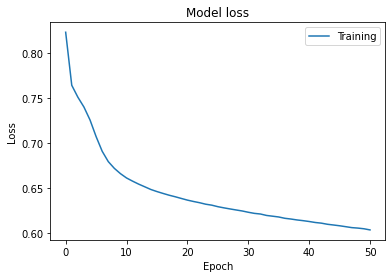

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

### Saving and loading variables for other sessions

If we want to generate new names with previously computed models, we need both the weights .hdf5 file (stored in the `checkpoints/` folder), and some of the variables created throughout this notebook, which we will save using the pickle module. We will load and generate the models in a separate file, `generator.ipynb` so as not to mess with this one.

In [29]:
def save_obj(obj, name ): # function saving the variable obj in a file called "name.pkl", within the variables/ folder
    with open(f'variables/case{case}/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [30]:
save_obj(validchars, "validchars")
save_obj(m, "m")
save_obj(max_char, "max_char")
save_obj(numchars, "numchars")
save_obj(char_to_index, "char_to_index")
save_obj(index_to_char, "index_to_char")